import all the necesarry library

In [126]:
import numpy as np
import pywt
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import math
from scipy.fftpack import dct
from scipy.fftpack import idct

from typing import List
import hashlib

In [127]:
maxVal = 63 # 0-255 -> valeur dans l'image
DctCoef = [3,3] # 0-8 -> coefficient de la DCT à utiliser
password = "my_password"

image = "original/cascade.jpg"
#image = "original/python.png"
marque = "original/marque.png"

# 124 caractères max
texte = "Le tatouage numérique (digital watermark, « filigrane numérique ») est une technique permettant d'ajouter des informations"
#texte = "Test d'insertion de text  !"

# Mode debug
np.set_printoptions(threshold=np.inf)

# Functions 

Function Convert and resize image 

In [128]:
def convertImage(imageName, size):
    img = Image.open(imageName).resize((size, size), 1) 
    # Convert image to jpeg if it is not
    """ if (img.format != 'JPEG'):
        img = img.convert('RGB')
        img.save('temp.jpg')
        img = Image.open('temp.jpg') """

    # Convert RGB image to YCbCr
    img = img.convert('YCbCr')
    # Split the YCbCr image into Y, Cb and Cr channels
    colors = img.split()
    # Convert the channel to a numpy array
    y = np.array(colors[0])
    Cb = np.array(colors[1])
    Cr = np.array(colors[2])
    img = y
    
    # Convert the numpy array to a PIL image
    img = Image.fromarray(img)
    imageArray = np.array(img.getdata(), dtype=float).reshape((size, size))
    return imageArray, colors


def convertMark(imageName, size):
    mark = Image.open(imageName).resize((size, size), 1)
    # Convert RGB image to gray scale
    mark = mark.convert('L')
    # Converting the gray scale image to binary image
    mark = mark.point(lambda x: 0 if x < 128 else maxVal, '1')
    # Inverting the binary image if there are more 255s than 0s
    if (np.sum(mark) > (size * size / 2)):
        mark = mark.point(lambda x: 0 if x == maxVal else maxVal, '1')

    markArray = np.array(mark.getdata(), dtype=float).reshape((size, size))
    return markArray

Convert text

In [129]:
#image = "original/image.jpg"
#texte = "Test d'insertion de texte  !"

def utf8_to_binary_matrix(text: str) -> np.ndarray: 
    # Convert the text to a bytearray in UTF-8 encoding
    byte_array = bytearray(text.encode("utf-8"))

    # Convert each byte to binary and concatenate them into a string
    binary_string = "".join(f"{byte:08b}" for byte in byte_array)
        
    # Create a numpy matrix array of 32x32 padded with 0
    binary_matrix = np.full((32, 32), 0, dtype=int)

    # Put the binary string into the matrix
    for i in range(len(binary_string)):
        binary_matrix[i // 32][i % 32] = int(binary_string[i])
    
    # Convert 1 to 255 and 0 to 0    
    binary_matrix = binary_matrix * (maxVal*3.6)
    print(binary_matrix)
    return binary_matrix


def binary_list_to_utf8(binary_list: List[int]) -> str:
    # Inverse the conversion of 1 to 255 and 0 to 0
    binary_list = [0 if x < (maxVal*2.3) else 1 for x in binary_list]
    # Convert the binary list to a binary string
    binary_string = "".join(map(str, binary_list))
    # Convert the binary string to a bytearray and then to a string in UTF-8 encoding
    byte_array = bytearray(int(binary_string[i:i+8], 2) for i in range(0, len(binary_string), 8))
    # Convert the binary string to a bytearray and then to a string in UTF-8 encoding,
    # replacing unknown characters with a dash
    try:
        byte_array = bytearray(int(binary_string[i:i+8], 2) for i in range(0, len(binary_string), 8))
        text = byte_array.decode("utf-8", errors="strict")
    except UnicodeDecodeError as e:
        byte_array = bytearray(int(binary_string[i:i+8], 2) if binary_string[i:i+8] != "00000000" else 45 for i in range(0, len(binary_string), 8))
        text = byte_array.decode("utf-8", errors="replace")
    return text

(128*128)/8 = 2048 caracters can be embedded in an image

Function that embedded watermark image into cover image

In [130]:
# Embed watermark into the cover image
def embedWatermark(watermarkArray, pixel_positions, originalImage):
    watermarkFlat = watermarkArray.ravel() # ravel() is used to convert 2D array to 1D array
    ind = 0
    for x, y in pixel_positions:
        if ind < len(watermarkFlat):
            subdct = originalImage[x*8:x*8+8, y*8:y*8+8]
            # Embed the fingerprint pixels into mid-Highfrequency cell of the 8x8 block.
            subdct[DctCoef[0]][DctCoef[1]] = watermarkFlat[ind]
            originalImage[x*8:x*8+8, y*8:y*8+8] = subdct
            ind += 1
    return originalImage 

Function that apply Discrete Cosine Transform on an 8x8 block

In [131]:
# DCT transform on image, i.e. image array
def applyDCT(imageArray):
    size = len(imageArray[0])
    allSubdct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subpixels = imageArray[i:i+8, j:j+8]
            subdct = dct(dct(subpixels.T, norm="ortho").T, norm="ortho")
            allSubdct[i:i+8, j:j+8] = subdct
    return allSubdct

Function that apply Inverse Discrete Cosine Transform on an 8x8 block

In [132]:
def inverseDCT(allSubdct):
    size = len(allSubdct[0])
    allSubidct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subidct = idct(idct(allSubdct[i:i+8, j:j+8].T, norm="ortho").T, norm="ortho")
            allSubidct[i:i+8, j:j+8] = subidct
    return allSubidct

Function that extract watermark image from embedded image

In [133]:
def getWatermark(dctWatermarkedCoeff, pixel_positions, watermarkSize):
    subwatermarks = []
    for x, y in pixel_positions:
        coeffSlice = dctWatermarkedCoeff[x*8:x*8+8, y*8:y*8+8]
        subwatermarks.append(coeffSlice[DctCoef[0]][DctCoef[1]])
    watermark = np.array(subwatermarks).reshape(watermarkSize, watermarkSize)
    return watermark

In [134]:
def password_to_position(password, size):
    """ Here is an implementation of a Python function that takes a password 
    as a parameter and returns a 1024-pixel position in a 128x128 grid: """
    # Convert password to a string of bytes
    password_bytes = password.encode('utf-8')
    # Initialize the hash with the password bytes
    hash_bytes = password_bytes
    hash_bytes = hashlib.sha256(hash_bytes).digest()
    # Repeat the hashing process 32 times to generate 1024 integers
    # 256/8 * 32 = 32 * 32 = 1024
    x_hash_bytes = b''
    y_hash_bytes = b''
    for i in range(32+6): # +6 to be sure to have 1024 different pixels
        # Compute the SHA-256 hash of the previous hash bytes
        x_hash_bytes += hashlib.sha256(hash_bytes+x_hash_bytes).digest()
        y_hash_bytes += hashlib.sha256(x_hash_bytes).digest()
        
    # Convert the hash bytes to a list of integers
    x_hash_ints = [int(byte) for byte in x_hash_bytes]
    y_hash_ints = [int(byte) for byte in y_hash_bytes]
    # Map each integer to a position in a 128x128 grid
    x_positions = [position % 128 for position in x_hash_ints]
    y_positions = [position % 128 for position in y_hash_ints]
    pixel_positions = list(zip(x_positions, y_positions))

    # Remove duplicates
    pixel_positions = list(set(pixel_positions))
    # Keep only the first positions
    pixel_positions = pixel_positions[:size]
    
    return pixel_positions


This function uses the SHA-256 hash function to generate a random sequence of bytes from the password. The first 1024 bytes of the hash are used to generate the pixel positions in a 128x128 grid. Each byte is mapped to a position in the grid by taking its value modulo 128 for the x-coordinate and its value divided by 128 for the y-coordinate.

The function returns a list of 1024 (x, y) tuples representing the pixel positions in the grid. These positions can be used to generate an image of the password, by coloring the pixels at the corresponding positions.

Correction of the watermark image

In [135]:
def jpegCorrection(watermarkArray):
    # Convertion de toutes les valeur entre 40 et 60 en 255 et le reste en 0
    watermarkArray[watermarkArray > maxVal+13] = 255 # Blanc
    watermarkArray[watermarkArray < maxVal-13] = 255
    watermarkArray[watermarkArray != 255] = 0 # Noir -> Marque
    return watermarkArray

def jpegCorrection2(watermarkArray):
    # Convertion de toutes les valeur entre 40 et 60 en 255 et le reste en 0
    watermarkArray[watermarkArray > maxVal*3.6+13] = 255 # Blanc
    watermarkArray[watermarkArray < maxVal*2.6-13] = 255
    watermarkArray[watermarkArray != 255] = 0 # Noir -> Marque
    return watermarkArray

# Place à 0 les valeurs inférieures à 30 et place à 255 les valeurs supérieures à 225 puis séparation à 128
def threshold(image):
    #image[image < 15] = 0
    #image[image > 240] = 0
    image[image > 128] = 255
    image[image < 128] = 0
    return image

Function for save image

In [136]:
def printImage(imageArray, name):
    imageArrayCopy = imageArray.clip(0, 255)
    imageArrayCopy = imageArrayCopy.astype("uint8")
    img = Image.fromarray(imageArrayCopy)
    img.save('result/' + name)

Function that recover watermark image using 2 key

In [137]:
def recoverWatermark(image, password, outputImageName=None):
    coeffsWatermarkedImage=list(pywt.wavedec2(data = image, wavelet = 'haar', level = 1))
    dctWatermarkedCoeff = applyDCT(coeffsWatermarkedImage[0])
    pixel_positions = password_to_position(password, 1024)
    watermarkArray = getWatermark(dctWatermarkedCoeff, pixel_positions, 32)

    watermarkArray =  np.uint8(watermarkArray)
    watermarkArray = jpegCorrection(watermarkArray)
    
    #Save result
    if outputImageName != None:
        printImage(watermarkArray, outputImageName)
    else:
        printImage(watermarkArray, 'recoveredWatermark.png')
    return watermarkArray



def recoverText(image, password):
    coeffsWatermarkedImage=list(pywt.wavedec2(data = image, wavelet = 'haar', level = 1))
    dctWatermarkedCoeff = applyDCT(coeffsWatermarkedImage[0])
    
    # Fonction getText à ajouter ! pour retourner une liste et la bonne taille 
    pixel_positions = password_to_position(password, 1024) 
    watermarkArray = getWatermark(dctWatermarkedCoeff, pixel_positions, 32)

    #watermarkArray = jpegCorrection2(watermarkArray)    
    watermarkArray = [int(j) for j in watermarkArray.flatten()] 
    watermarkArray = binary_list_to_utf8(watermarkArray)
    
    # Look for dash in the text to know where the watermark ends if 3 dashes are found next to each other cut the text
    dashCount = 0
    for i in range (0, len(watermarkArray)-1, 1):
        if watermarkArray[i] == '-':
            dashCount += 1
        else:
            dashCount = 0
        if dashCount == 3:
            watermarkArray = watermarkArray[:i-2]
            break
        
    #Save result in txt file
    else :
        file = open('result/recoveredText.txt', 'w')
        file.write(watermarkArray)
        file.close()
    return watermarkArray

Function that embedded watermark image into cover
image

In [138]:
def embeddedImage(coverImage, watermarkImage, password):
    imageArray, colors = convertImage(coverImage, 2048)
    watermarkArray = convertMark(watermarkImage, 32) # 128/4
    
    pixel_positions = password_to_position(password, 1024)

    coeffsImage = list(pywt.wavedec2(data=imageArray, wavelet = 'haar', level = 1))
    dctArray = applyDCT(coeffsImage[0]) # [0] corresponds to cH subband (cH = LH)
    dctArray = embedWatermark(watermarkArray, pixel_positions, dctArray)

    coeffsImage[0] = inverseDCT(dctArray)
    imageArrayH=pywt.waverec2(coeffsImage, 'haar')
    
    # Get Y Cb Cr channels
    y, Cb, Cr = colors
    # Convert the numpy array back to an image
    y = Image.fromarray(imageArrayH.astype('uint8'))

    # Put the red channel back in the RGB image
    colors = (y, Cb, Cr)

    # Save result
    img = Image.merge('YCbCr', colors).convert('RGB')
    img.save('result/watermarkedImage.jpg')
    img.save('result/watermarkedImage.png')
    
    return img


def embeddedTexte(coverImage, texte, password):
    imageArray, colors = convertImage(coverImage, 2048)
    texteArray = utf8_to_binary_matrix(texte)
    
    pixel_positions = password_to_position(password, 1024)

    coeffsImage = list(pywt.wavedec2(data=imageArray, wavelet = 'haar', level = 1))
    dctArray = applyDCT(coeffsImage[0])
    dctArray = embedWatermark(texteArray, pixel_positions, dctArray)

    coeffsImage[0] = inverseDCT(dctArray)
    imageArrayH=pywt.waverec2(coeffsImage, 'haar')
    
    # Get Y Cb Cr channels
    y, Cb, Cr = colors
    # Convert the numpy array back to an image
    y = Image.fromarray(imageArrayH.astype('uint8'))

    # Put the red channel back in the RGB image
    colors = (y, Cb, Cr)

    # Save result
    img = Image.merge('YCbCr', colors).convert('RGB')
    img.save('result/watermarkedImage.jpg')
    img.save('result/watermarkedImage.png')
    
    return img

# Testing

In [139]:
watermarkeImage = embeddedImage(image,marque, password) 
#watermarkeImage = embeddedTexte(image,texte, password)

In [140]:
watermarkeImage = cv2.imread("result/watermarkedImage.jpg")
watermarkeImage = cv2.resize(watermarkeImage, (2048, 2048))
watermarkeImage = cv2.cvtColor(watermarkeImage, cv2.COLOR_BGR2YCrCb)
watermarkeImage = watermarkeImage.astype(np.float32)
y = watermarkeImage[:,:,0]
Cb = watermarkeImage[:,:,1]
Cr = watermarkeImage[:,:,2]


""" # Read the image in CbCr color space
# Convert RGB image to YCbCr
watermarkeImg = watermarkeImage.convert('YCbCr')
# Split the YCbCr image into Y, Cb and Cr channels
colors = watermarkeImg.split()
# Convert the channel to a numpy array
y = np.array(colors[0])
Cb = np.array(colors[1])
Cr = np.array(colors[2]) """


# Select the channel
watermarkeImg = y
watermarkArray = recoverWatermark(watermarkeImg, password)
#watermarkArray = recoverText(watermarkeImg, password)
print(watermarkArray)

[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255   0 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255   0 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255   0]
 [255 255 255 255   0 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255   0 255 255 255 255 255 255 255]
 [255 255 255 255 255   0 255 255 255 255 255 255 255 255 255   0 255 255
    0 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255   0 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255   0   0 255 255 255 255 255   0 255

# Plot all three resultant image

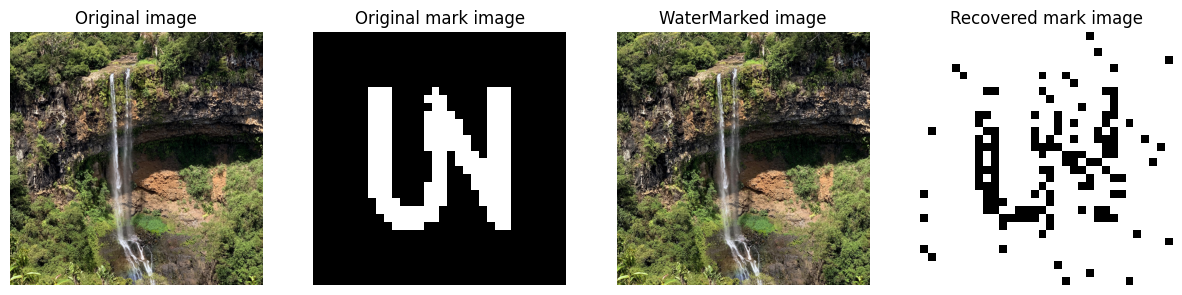

In [141]:
readImage = cv2.imread(image, cv2.COLOR_BGR2RGB)
waterimg = cv2.imread("result/watermarkedImage.jpg")
recovwater = cv2.imread("result/recoveredWatermark.png", cv2.IMREAD_GRAYSCALE)

marqueImg = Image.open(marque).resize((32, 32), 1)
marqueImg = marqueImg.convert('L')
marqueImg = marqueImg.point(lambda x: 0 if x < 128 else 255, '1')
    

plt.figure(figsize = (15,15))
plt.subplot(1,4,1),plt.imshow(cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)),plt.title("Original image"), plt.axis('off')
plt.subplot(1,4,2),plt.imshow(marqueImg),plt.title("Original mark image"), plt.axis("off")
plt.subplot(1,4,3),plt.imshow(cv2.cvtColor(waterimg, cv2.COLOR_BGR2RGB)),plt.title("WaterMarked image"), plt.axis("off")
plt.subplot(1,4,4),plt.imshow(recovwater, cmap = 'gray'),plt.title("Recovered mark image"), plt.axis("off")
plt.show()

- Image :
Mean of difference :  5.6594029267628985 
Max of difference : 255 
Number of different pixels :  11549815 / 12582912 = 91.78 %

- Mark :
Mean of difference :  28.88671875 
Max of difference :  255 
Number of different pixels :  116 / 1024 = 11.32 %


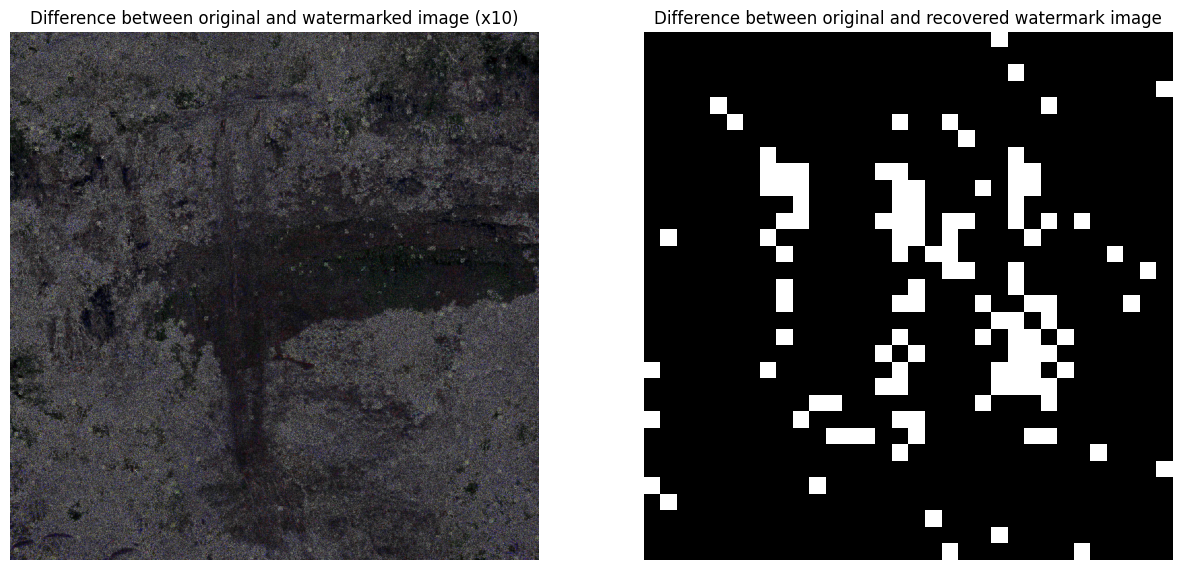

In [142]:
# Resize original image to the same size as watermarked image
readImageModif = cv2.resize(readImage, (2048, 2048))
# Convert recovered watermark from numpy.ndarray to PIL.Image
#recovwaterImg = Image.fromarray(recovwater)

# Convert marqueImg from binary PIL to numpy array
marqueNp = np.array(marqueImg)
# Convert True to 1 and False to 0
marqueNp = np.where(marqueNp == True, 255, 0)
marqueNp = np.array(marqueNp, dtype = np.uint8)
# Invert the image
marqueNp = cv2.bitwise_not(marqueNp)

# Compute and Plot difference between original and watermarked image
diffimg = cv2.absdiff(readImageModif, waterimg)
diffmark = cv2.absdiff(marqueNp, recovwater)

# Number of different pixels
pixelimg = np.where(diffimg > 0, 1, 0)
pixelmark = np.where(diffmark > 0, 1, 0)

print("- Image :\nMean of difference : ", str(np.mean(diffimg)), "\nMax of difference : " + str(np.max(diffimg)), 
      "\nNumber of different pixels : ", str(np.sum(pixelimg)), "/", str(np.size(diffimg)), "=", str(np.sum(pixelimg)/np.size(diffimg)*100)[:5], "%")
print("\n- Mark :\nMean of difference : ", str(np.mean(diffmark)), "\nMax of difference : ", str(np.max(diffmark)), 
      "\nNumber of different pixels : ", str(np.sum(pixelmark)), "/", str(np.size(diffmark)), "=", str(np.sum(pixelmark)/np.size(diffmark)*100)[:5], "%")

plt.figure(figsize = (15,15))
plt.subplot(1,2,1),plt.imshow(cv2.cvtColor(diffimg*10, cv2.COLOR_BGR2RGB)),plt.title("Difference between original and watermarked image (x10)"), plt.axis("off")
plt.subplot(1,2,2),plt.imshow(cv2.cvtColor(diffmark, cv2.COLOR_BGR2RGB)),plt.title("Difference between original and recovered watermark image"), plt.axis("off")
plt.show()

---

# Calculate PSNR value

In [143]:
def pastingImage (img1, img2):
    temp = img2.copy()
    x_offset=y_offset=50
    img2[y_offset:y_offset+img1.shape[0], x_offset:x_offset+img1.shape[1]] = img1
    
    return img2, temp

In [144]:
def compute_psnr(img1, img2):
    
    img1 = img1.astype(float) / 255.
    img2 = img2.astype(float) / 255.
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return "Same Image"
    return 10 * math.log10(1. / mse)

In [145]:
def NCC(img1, img2):
    return abs(np.mean(np.multiply((img1-np.mean(img1)),(img2-np.mean(img2))))/(np.std(img1)*np.std(img2)))

In [146]:
img1 = cv2.imread("original/image.jpg",0)
img1 = cv2.resize(img1, (512, 512))
img2 = cv2.imread("result/watermarkedImage.jpg",0)
img1, img2 = pastingImage(img1,img2)

psnr = compute_psnr(img1, img2)
print (f'PSNR value of resultant image is {psnr}')

PSNR value of resultant image is 22.158638767335933


In [147]:
print (f'Normalized cross correlation is {NCC(img1, img2)}')

Normalized cross correlation is 0.9488632934185053


# Attacks (Geometric & Signal Processing)

In [148]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col= image.shape
        mean = 0
        #var = 0.001
        var = 0.05
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        #noisy = image + gauss
        noisy = image + image * gauss
        return noisy
    elif noise_typ == "s&p":
        row,col = image.shape
        s_vs_p = 0.5
        #amount = 0.01 # 0.10% of pixels ?
        amount = 0.00003
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image)) 
        vals = 2 ** np.ceil(np.log2(vals))
        #noisy = np.random.poisson(image * vals) / float(vals) 
        noisy = np.random.poisson(image * vals) / float(vals) * 1.5
        return noisy
    elif noise_typ =="speckle":
        row,col = image.shape
        gauss = np.random.randn(row,col)
        gauss = gauss.reshape(row,col)        
        #noisy = image + image * gauss
        noisy = image + image * gauss*0.25
        return noisy
    elif noise_typ == "rotate90" :
        angle = 90
        scale = 1.0
        w = image.shape[1]
        h = image.shape[0]
        rangle = np.deg2rad(angle)  # angle in radians
        nw = (abs(np.sin(rangle) * h) + abs(np.cos(rangle) * w)) * scale
        nh = (abs(np.cos(rangle) * h) + abs(np.sin(rangle) * w)) * scale
        rot_mat = cv2.getRotationMatrix2D((nw * 0.5, nh * 0.5), angle, scale)
        rot_move = np.dot(rot_mat, np.array(
            [(nw - w) * 0.5, (nh - h) * 0.5, 0]))
        rot_mat[0, 2] += rot_move[0]
        rot_mat[1, 2] += rot_move[1]
        noisy=cv2.warpAffine(image, rot_mat, (int(math.ceil(nw)), int(math.ceil(nh))), flags=cv2.INTER_LANCZOS4)
        return noisy
    elif noise_typ=="chop30":
        img = image.copy()
        w, h = img.shape[:2]
        # chop off 30% of the top of the image
        #noisy=img[int(w * 0.3):, :] 
        # chop off 15% of the top of the image and 15% of the bottom
        noisy=img[int(w * 0.15):int(w * 0.85), :]
        return noisy
    
    elif noise_typ=="jpeg":
        # encode image as a jpeg with quality 50
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 45]
        result, encimg = cv2.imencode('.jpg', image, encode_param)
        # decode image
        decimg = cv2.imdecode(encimg, 1)
        decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)
        decimg = cv2.cvtColor(decimg, cv2.COLOR_RGB2GRAY)
        return decimg


In [149]:
def restoreCrop(img):
    # Add null information to the borders of a cropped image to make it 2048x2048 in size:
    # Get the dimensions of the cropped image
    height, width = img.shape

    # Create a new black image of size 2048x2048
    new_img = np.zeros((2048, 2048), dtype=np.uint8)

    # Calculate the position to place the cropped image in the center of the new image
    x_offset = int((2048 - width) / 2)
    y_offset = int((2048 - height) / 2)

    # Add the cropped image to the center of the new image
    new_img[y_offset:y_offset+height, x_offset:x_offset+width] = img

    return new_img

Without attack
			 PSNR de l'image : 28.305025154067046
			 PSNR de la marque : 9.458419674128935



+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
				 Compression Attacks
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++




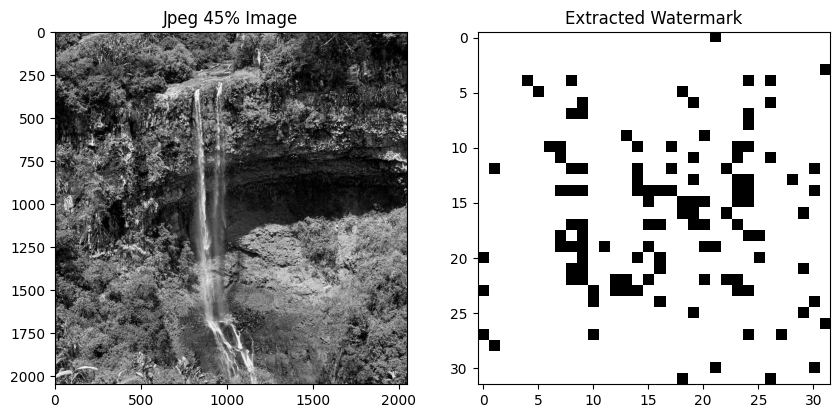

			 PSNR de l'image : 27.104178274146395
			 PSNR de la marque : 8.342086975841308



+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
				 Geometric Attacks
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


				 Rotate 90°
-----------------------------------------------------------------------------------------


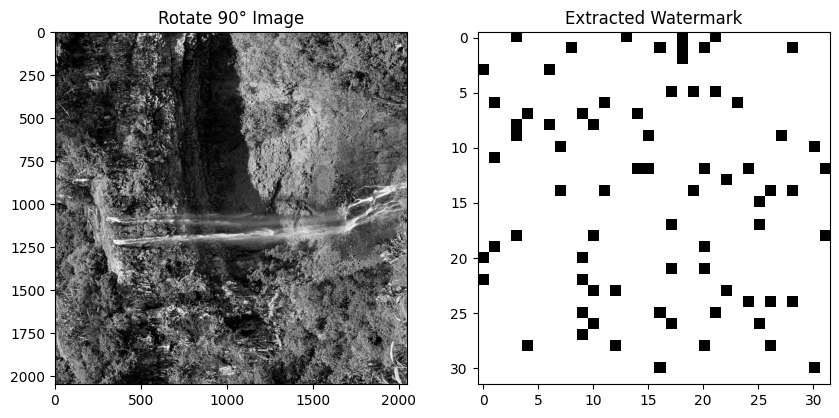

			 PSNR de l'image : 9.20911824454806
			 PSNR de la marque : 6.600519383056492
			 Normalized cross correlation de l'image : 0.04216437924260648
******************************************************************************************
				 Chop 30
-----------------------------------------------------------------------------------------


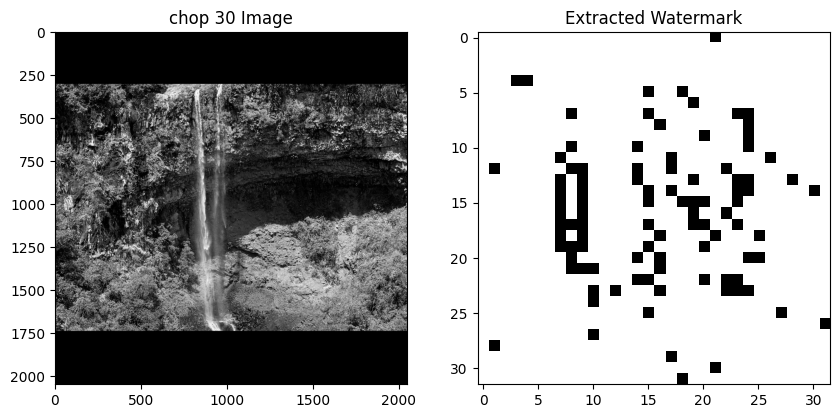

			 PSNR de l'image : 12.674794718164936
			 PSNR de la marque : 8.930286609840476
******************************************************************************************



+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
				 Image Filtering Attacks
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


				 Gaussian Noise 
-----------------------------------------------------------------------------------------


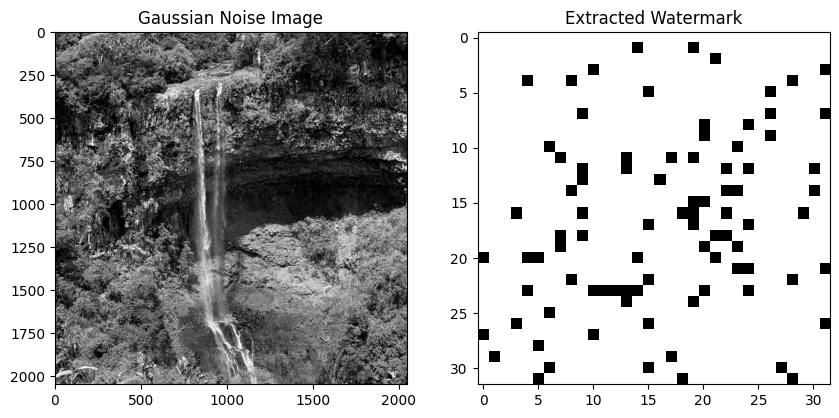

			 PSNR de l'image : 19.9846436776019
			 PSNR de la marque : 7.407870124218957
******************************************************************************************
				 Salt and Pepper Noise
-----------------------------------------------------------------------------------------


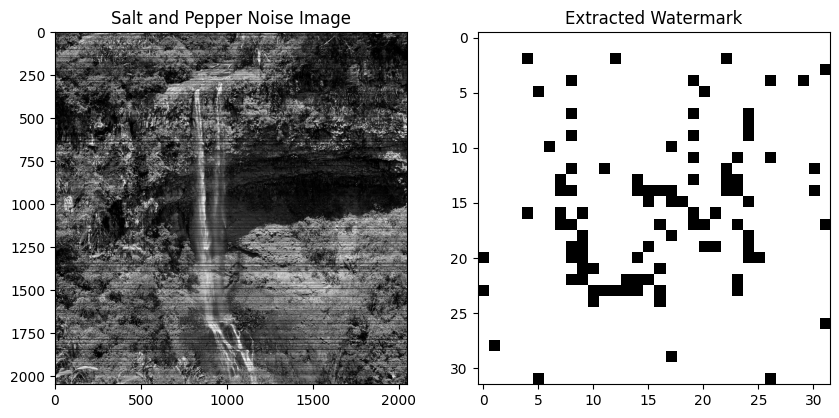

			 PSNR de l'image : 16.626414031664204
			 PSNR de la marque : 8.313230093466425
******************************************************************************************
				 Poisson Noise
-----------------------------------------------------------------------------------------


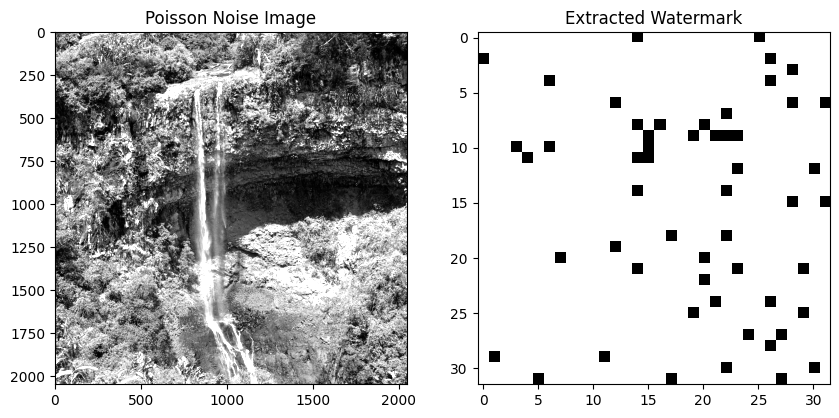

			 PSNR de l'image : 13.382973789484119
			 PSNR de la marque : 7.006697892139132
******************************************************************************************
				 Speckle Noise
-----------------------------------------------------------------------------------------


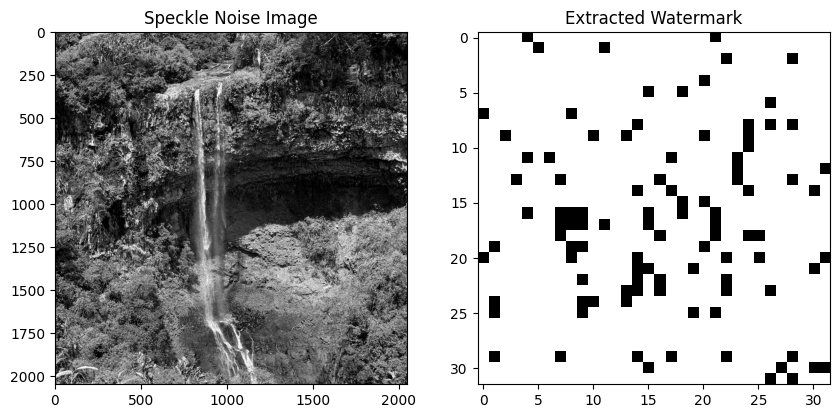

			 PSNR de l'image : 19.134389423997014
			 PSNR de la marque : 7.361421073761321
******************************************************************************************


In [150]:
originalImage = cv2.cvtColor(readImageModif, cv2.COLOR_BGR2GRAY)
originalMarque = marqueNp
watermarked = watermarkeImg

""" watermarked = embeddedImage(image,marque) 
# Convert to numpy and grayscale
watermarked = np.array(watermarked)
watermarked = cv2.cvtColor(watermarked, cv2.COLOR_BGR2GRAY) """

#extracted = cv2.imread("result/recoveredWatermark.png", cv2.IMREAD_GRAYSCALE)

print("Without attack")
extracted = recoverWatermark(watermarked, 'my_password')
print("\t\t\t PSNR de l'image :", compute_psnr(originalImage,watermarked))
print("\t\t\t PSNR de la marque :", compute_psnr(originalMarque,extracted))

print("\n\n")
print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print ('\t\t\t\t Compression Attacks')
print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n')
img = noisy( "jpeg",watermarked)
extracted = recoverWatermark(img, 'my_password', "jpeg.png")
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Jpeg 45% Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print("\t\t\t PSNR de l'image :", compute_psnr(originalImage,img))
print("\t\t\t PSNR de la marque :", compute_psnr(originalMarque,extracted))

print("\n\n")
print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print ('\t\t\t\t Geometric Attacks')
print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n')

print ("\t\t\t\t Rotate 90°")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "rotate90",watermarked)
extracted = recoverWatermark(img, 'my_password', "rotate90.png")
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Rotate 90° Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print("\t\t\t PSNR de l'image :", compute_psnr(originalImage,img))
print("\t\t\t PSNR de la marque :", compute_psnr(originalMarque,extracted))

#print ("\t\t\t Normalized cross correlation de l'image :", NCC(pastingImage(originalImage,img),img))
print ("\t\t\t Normalized cross correlation de l'image :", NCC(originalImage,img))
print ("******************************************************************************************")
print ("\t\t\t\t Chop 30")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "chop30",watermarked)
img = restoreCrop(img)
extracted = (recoverWatermark(img, 'my_password', "crop.png")) # Image.fromarray(recoverWatermark(img))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("chop 30 Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print("\t\t\t PSNR de l'image :", compute_psnr(originalImage,img))
print("\t\t\t PSNR de la marque :", compute_psnr(originalMarque,extracted))
#print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage,img),img))
print ("******************************************************************************************")

print("\n\n")
print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print ('\t\t\t\t Image Filtering Attacks')
print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n')

print ("\t\t\t\t Gaussian Noise ")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "gauss",watermarked)
extracted = (recoverWatermark(img, 'my_password', "noisy.png"))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Gaussian Noise Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print("\t\t\t PSNR de l'image :", compute_psnr(originalImage,img))
print("\t\t\t PSNR de la marque :", compute_psnr(originalMarque,extracted))
#print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage,img),img))
print ("******************************************************************************************")

print ("\t\t\t\t Salt and Pepper Noise")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "s&p",watermarked)
extracted = (recoverWatermark(img, 'my_password', "s&p.png"))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Salt and Pepper Noise Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print("\t\t\t PSNR de l'image :", compute_psnr(originalImage,img))
print("\t\t\t PSNR de la marque :", compute_psnr(originalMarque,extracted))
#print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage,img),img))
print ("******************************************************************************************")

print ("\t\t\t\t Poisson Noise")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "poisson",watermarked)
extracted = (recoverWatermark(img, 'my_password', "poisson.png"))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Poisson Noise Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print("\t\t\t PSNR de l'image :", compute_psnr(originalImage,img))
print("\t\t\t PSNR de la marque :", compute_psnr(originalMarque,extracted))
#print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage, img), img))
print ("******************************************************************************************")

print ("\t\t\t\t Speckle Noise")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "speckle",watermarked)
extracted = (recoverWatermark(img, 'my_password', "speckle.png"))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Speckle Noise Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print("\t\t\t PSNR de l'image :", compute_psnr(originalImage,img))
print("\t\t\t PSNR de la marque :", compute_psnr(originalMarque,extracted))
#print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage, img), img))
print ("******************************************************************************************")